# **Data Preprocessing & Pandas with Kaggle Playground (Oct 2025)**

**Goal of this notebook**
- Load `train.csv`, `test.csv`, and understand their structure.
- Inspect data types, missing values, and basic distributions.
- Prepare for cleaning, feature engineering, and a baseline submission.

**Files**
- `train.csv` — includes features + target.
- `test.csv` — includes features only (no target).
- `sample_submission.csv` — shows the expected submission format.


In [2]:
# If library is not installed, use %pip install library name
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Pandas version:", pd.__version__)


Pandas version: 2.0.3


In [4]:
# Define paths
TRAIN_PATH = "./data/train.csv"
TEST_PATH = "./data/test.csv"

## Load & First Look

We'll:
1) Read `train.csv` and `test.csv` with pandas.
2) Peek at a few rows.
3) Check shapes, column names, and data types.
4) Get a first pass on missing values and basic stats.


In [5]:
# na_values covers common placeholders; adjust if your competition uses special tokens
read_csv_opts = dict(low_memory=False, na_values=["", "NA", "NaN", "null"])

train = pd.read_csv(TRAIN_PATH, **read_csv_opts)
test  = pd.read_csv(TEST_PATH, **read_csv_opts)

print("train shape:", train.shape)
print("test  shape:", test.shape)


FileNotFoundError: [Errno 2] No such file or directory: './data/train.csv'

In [25]:
display(train.head())
display(test.head(3))

print("\nColumns in train:")
print(list(train.columns))

print("\nColumns in test:")
print(list(test.columns))

# A random peek 
display(train.sample(5))


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.0600,35,daylight,rainy,False,True,afternoon,False,True,1,0.1300
1,1,urban,4,0.9900,35,daylight,clear,True,False,evening,True,True,0,0.3500
2,2,rural,4,0.6300,70,dim,clear,False,True,morning,True,False,2,0.3000
3,3,highway,4,0.0700,35,dim,rainy,True,True,morning,False,False,1,0.2100
4,4,rural,1,0.5800,60,daylight,foggy,False,False,evening,True,False,1,0.5600


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.3400,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.0400,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.5900,35,dim,clear,True,False,afternoon,True,True,1



Columns in train:
['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']

Columns in test:
['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
115210,115210,highway,4,0.6100,45,dim,clear,True,False,evening,True,True,0,0.2500
272270,272270,rural,2,0.1200,60,daylight,clear,True,True,morning,True,True,2,0.3200
498846,498846,highway,2,0.2600,45,daylight,clear,False,True,evening,False,False,0,0.0900
405993,405993,urban,4,0.0700,70,dim,foggy,True,False,afternoon,True,True,0,0.2900
138475,138475,highway,2,0.1000,25,night,clear,False,False,morning,False,True,3,0.2200


In [30]:
# Built in method for inspection
print("=== train.info() ===")
train.info()
print("\n=== test.info() ===")
test.info()

# dtype summary tables
dtype_train = train.dtypes.value_counts().rename_axis("dtype").to_frame("count")
dtype_test  = test.dtypes.value_counts().rename_axis("dtype").to_frame("count")
display(dtype_train.style.set_caption("Train dtypes"))
display(dtype_test.style.set_caption("Test dtypes"))


=== train.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtyp

,count
dtype,
int64,4
object,4
bool,4
float64,2


,count
dtype,
int64,4
object,4
bool,4
float64,1


In [ ]:
# Numeric summary - Averages, Percentiles, etc.
display(train.describe().T.style.set_caption("Numeric summary (train)"))

# Categorical summary: how many unique values and top frequencies
def categorical_overview(df, max_cols=20):
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    overview = []
    for c in cat_cols[:max_cols]:
        vc = df[c].value_counts(dropna=False)
        top = vc.index[0] if len(vc) else None
        top_count = vc.iloc[0] if len(vc) else None
        overview.append({
            "column": c,
            "n_unique": df[c].nunique(dropna=True),
            "most_frequent": top,
            "most_frequent_count": int(top_count) if top_count is not None else None,
            "n_missing": int(df[c].isna().sum())
        })
    return pd.DataFrame(overview).sort_values("n_missing", ascending=False)

display(categorical_overview(train).style.set_caption("Categorical overview (train)"))


,count,mean,std,min,25%,50%,75%,max
id,517754.000000,258876.500000,149462.849974,0.000000,129438.250000,258876.500000,388314.750000,517753.000000
num_lanes,517754.000000,2.491511,1.120434,1.000000,1.000000,2.000000,3.000000,4.000000
curvature,517754.000000,0.488719,0.272563,0.000000,0.260000,0.510000,0.710000,1.000000
speed_limit,517754.000000,46.112575,15.788521,25.000000,35.000000,45.000000,60.000000,70.000000
num_reported_accidents,517754.000000,1.187970,0.895961,0.000000,1.000000,1.000000,2.000000,7.000000
accident_risk,517754.000000,0.352377,0.166417,0.000000,0.230000,0.340000,0.460000,1.000000


,column,n_unique,most_frequent,most_frequent_count,n_missing
0,road_type,3,highway,173672,0
1,lighting,3,dim,183826,0
2,weather,3,foggy,181463,0
3,time_of_day,3,morning,173410,0


In [32]:
def missing_summary(df, min_missing=1):
    miss = df.isnull().sum()
    miss = miss[miss >= min_missing].sort_values(ascending=False)
    if miss.empty:
        return pd.DataFrame({"column": [], "n_missing": [], "pct_missing": []})
    out = pd.DataFrame({
        "column": miss.index,
        "n_missing": miss.values,
        "pct_missing": (miss.values / len(df) * 100).round(2)
    })
    return out

print("=== Missing values (train) ===")
display(missing_summary(train))
print("=== Missing values (test) ===")
display(missing_summary(test))


=== Missing values (train) ===


,column,n_missing,pct_missing


=== Missing values (test) ===


,column,n_missing,pct_missing


## Data Quality Checks + Data Cleaning

In [ ]:
# Count duplicates
print("Number of duplicate rows in train:", train.duplicated().sum())
print("Number of duplicate rows in test:", test.duplicated().sum())

# Optionally drop them (if any)
# train = train.drop_duplicates().reset_index(drop=True)
# test = test.drop_duplicates().reset_index(drop=True)


Number of duplicate rows in train: 0
Number of duplicate rows in test: 0


0

In [35]:
# Check for and "impossible" values, such as negative or weird values in numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
print("Min/max values for numeric columns:")
display(train[numeric_cols].agg(['min', 'max']).T)


Min/max values for numeric columns:


,min,max
id,0.0000,"517,753.0000"
num_lanes,1.0000,4.0000
curvature,0.0000,1.0000
speed_limit,25.0000,70.0000
num_reported_accidents,0.0000,7.0000
accident_risk,0.0000,1.0000


In [38]:
# Compare categories between train and test
# This step may seem unecessary for now, but will make more sense when we do encoding

cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_cats = set(train[col].unique())
    test_cats = set(test[col].unique())
    extra_in_test = test_cats - train_cats
    if extra_in_test:
        print(f"'{col}' has categories in test not seen in train: {extra_in_test}")


In [39]:
# Adjusting data types
# Again, useful for encoding later on

# Convert categorical object columns to 'category' dtype
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# Convert boolean columns to integers if desired
bool_cols = train.select_dtypes(include=['bool']).columns
for col in bool_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int64   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int64   
 3   curvature               517754 non-null  float64 
 4   speed_limit             517754 non-null  int64   
 5   lighting                517754 non-null  category
 6   weather                 517754 non-null  category
 7   road_signs_present      517754 non-null  int32   
 8   public_road             517754 non-null  int32   
 9   time_of_day             517754 non-null  category
 10  holiday                 517754 non-null  int32   
 11  school_season           517754 non-null  int32   
 12  num_reported_accidents  517754 non-null  int64   
 13  accident_risk           517754 non-null  float64 
dtypes: c

In [40]:
#Let's have a look at the final shapes and columns

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())


Train shape: (517754, 14)
Test shape: (172585, 13)
Train columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']
Test columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


## Exploratory Data Analysis

Starting with univariate analysis - exploring individual columns, their distributions, value counts, and ranges.  
This helps us spot unusual values and understand how features are distributed.

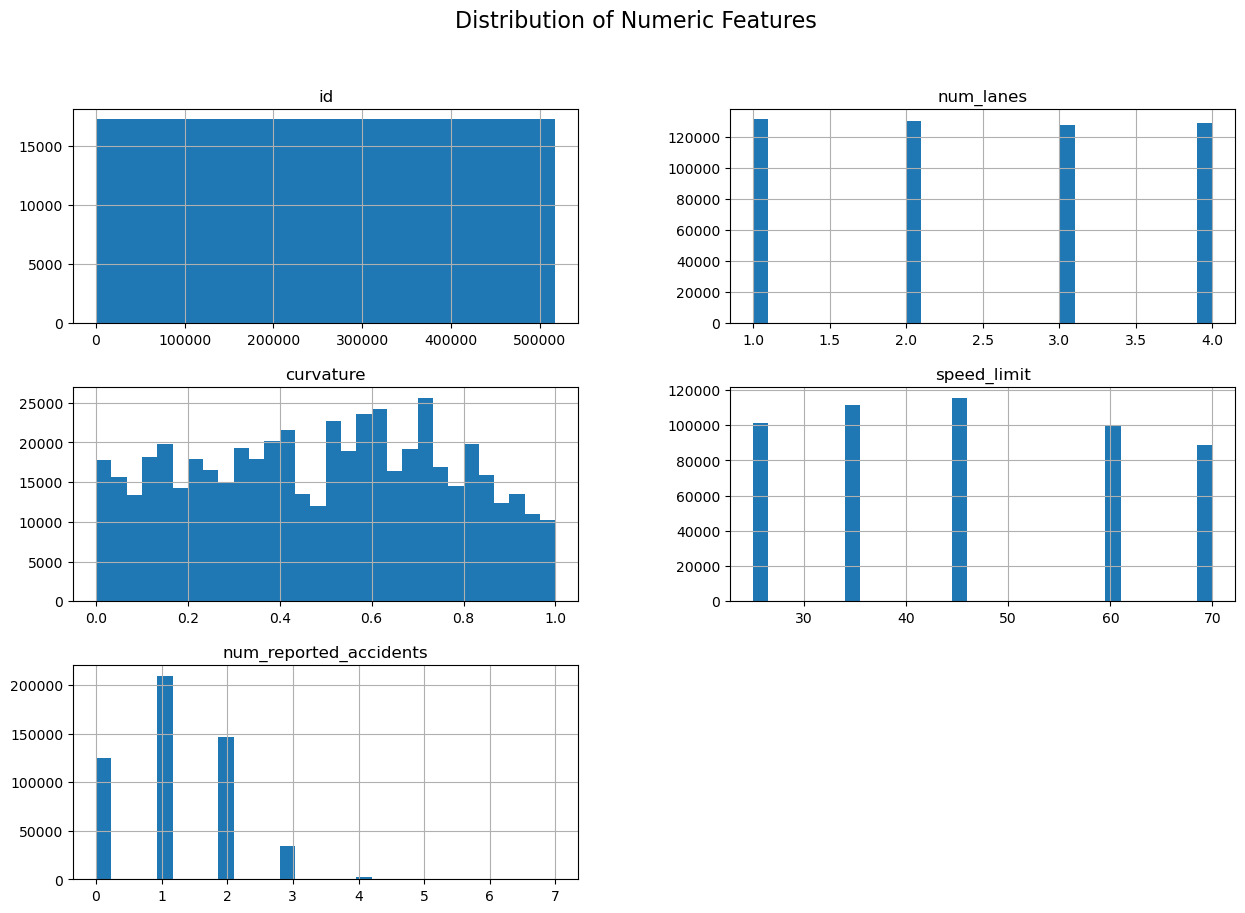

,count,mean,std,min,25%,50%,75%,max
id,"517,754.0000","258,876.5000","149,462.8500",0.0000,"129,438.2500","258,876.5000","388,314.7500","517,753.0000"
num_lanes,"517,754.0000",2.4915,1.1204,1.0000,1.0000,2.0000,3.0000,4.0000
curvature,"517,754.0000",0.4887,0.2726,0.0000,0.2600,0.5100,0.7100,1.0000
speed_limit,"517,754.0000",46.1126,15.7885,25.0000,35.0000,45.0000,60.0000,70.0000
num_reported_accidents,"517,754.0000",1.1880,0.8960,0.0000,1.0000,1.0000,2.0000,7.0000


In [42]:
# Histograms for numeric features
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('accident_risk', errors='ignore')
train[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

# Summary stats
display(train[numeric_cols].describe().T)


Now, time to look at bi-variate data. This is how all the data relates to each other

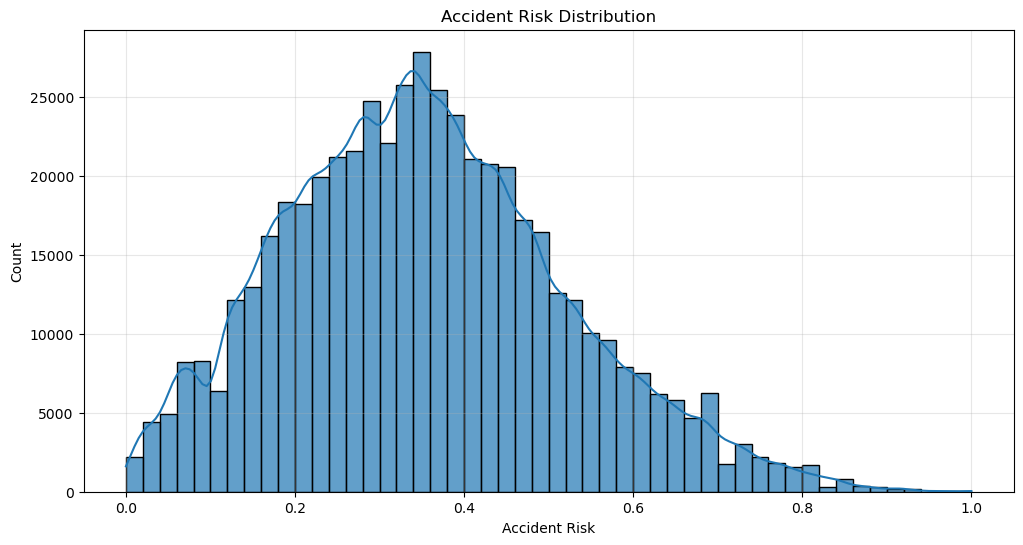

In [ ]:
# Risk distribution

plt.figure(figsize=(12,6))
sns.histplot(train['accident_risk'], bins=50, kde=True, alpha=0.7)
plt.title('Accident Risk Distribution')
plt.xlabel('Accident Risk')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

In [56]:
for col in cat_cols:
    display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
road_type,,
urban,0.3575,171363
rural,0.3500,172719
highway,0.3497,173672


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
lighting,,
night,0.4705,155913
daylight,0.3029,178015
dim,0.3001,183826


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
weather,,
foggy,0.3863,181463
rainy,0.3615,156985
clear,0.3101,179306


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
time_of_day,,
evening,0.3547,172837
afternoon,0.3514,171507
morning,0.3510,173410


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3479854795.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order=train.groupby('weather')['accident_risk'].mean().nlargest(12).index,


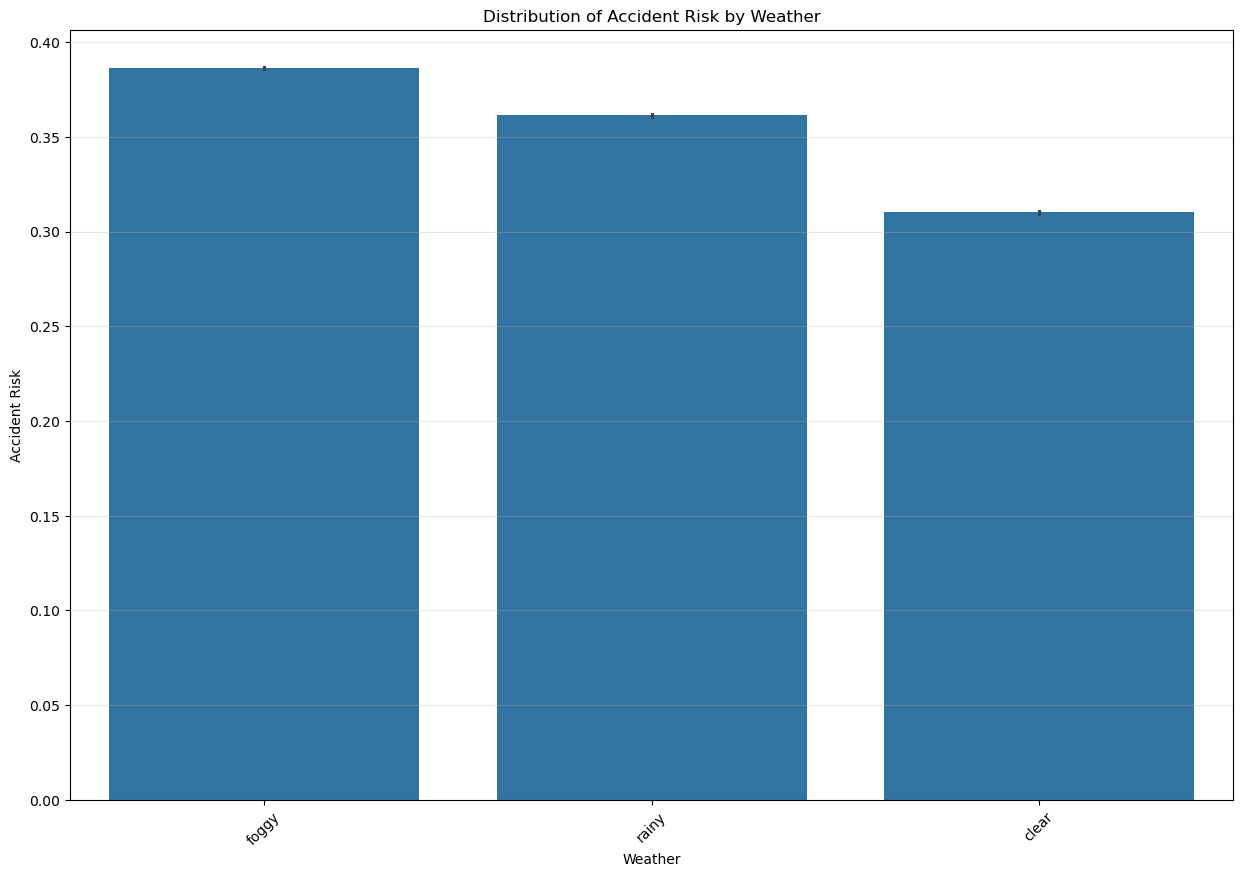

In [52]:
plt.figure(figsize=(15,10))
sns.barplot(
    x='weather',
    y='accident_risk',
    data=train,
    order=train.groupby('weather')['accident_risk'].mean().nlargest(12).index,
)

plt.title('Distribution of Accident Risk by Weather')
plt.xlabel('Weather')
plt.ylabel('Accident Risk')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

C:\Users\mones\AppData\Local\Temp\ipykernel_2972\4271292641.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order=train.groupby('road_type')['accident_risk'].mean().nlargest(12).index,


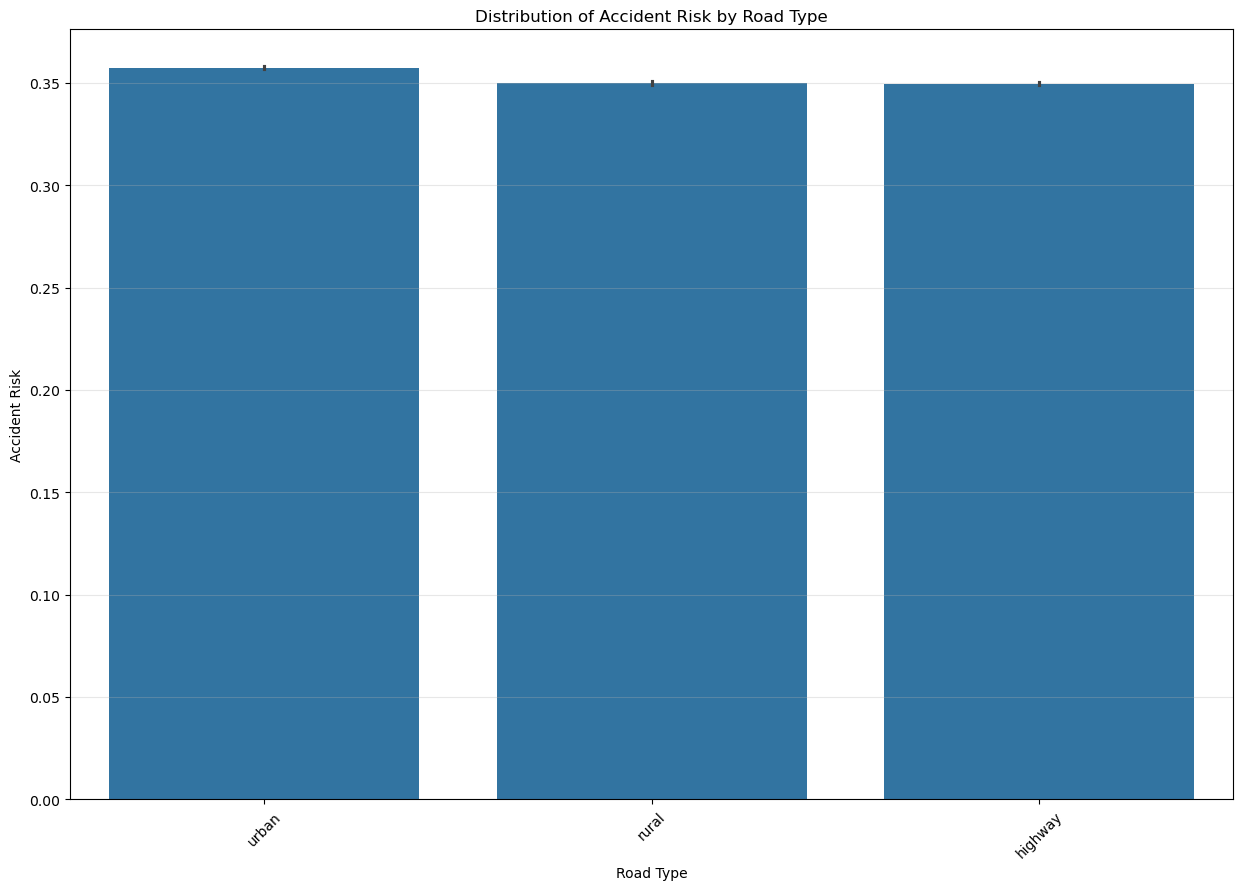

In [53]:
plt.figure(figsize=(15,10))
sns.barplot(
    x='road_type',
    y='accident_risk',
    data=train,
    order=train.groupby('road_type')['accident_risk'].mean().nlargest(12).index,
)

plt.title('Distribution of Accident Risk by Road Type')
plt.xlabel('Road Type')
plt.ylabel('Accident Risk')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

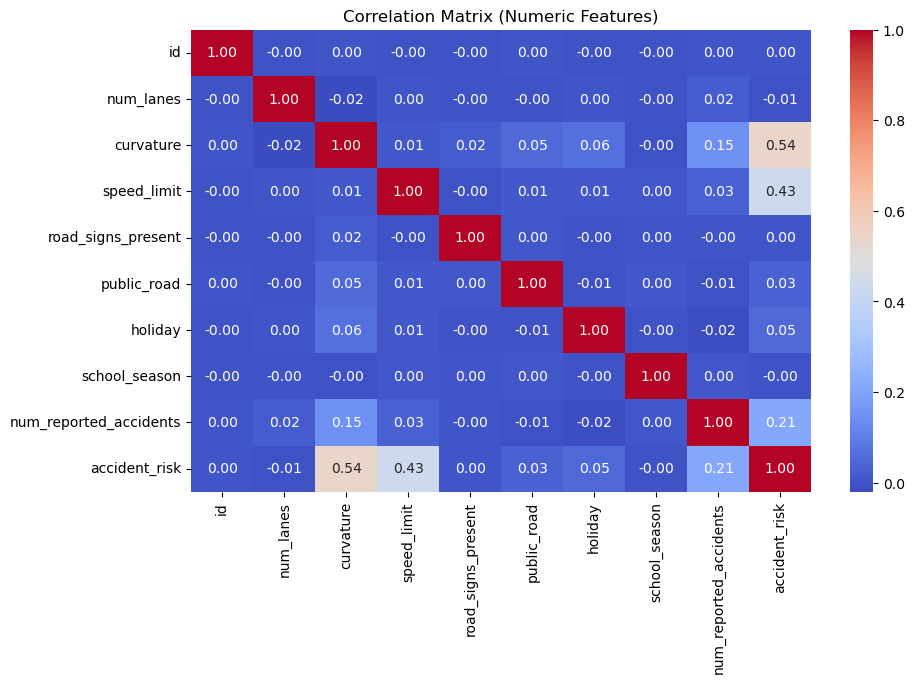

In [54]:
# Correlation matrix for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
road_type,,
urban,0.3575,171363
rural,0.3500,172719
highway,0.3497,173672


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
lighting,,
night,0.4705,155913
daylight,0.3029,178015
dim,0.3001,183826


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
weather,,
foggy,0.3863,181463
rainy,0.3615,156985
clear,0.3101,179306


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\3173014266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(train.groupby(col)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))


,mean,count
time_of_day,,
evening,0.3547,172837
afternoon,0.3514,171507
morning,0.3510,173410


C:\Users\mones\AppData\Local\Temp\ipykernel_2972\1342992296.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = train.groupby(col)[target].mean().sort_values(ascending=False).index


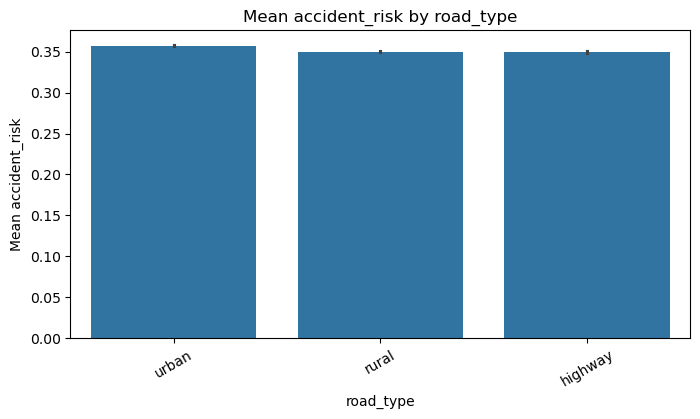

C:\Users\mones\AppData\Local\Temp\ipykernel_2972\1342992296.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = train.groupby(col)[target].mean().sort_values(ascending=False).index


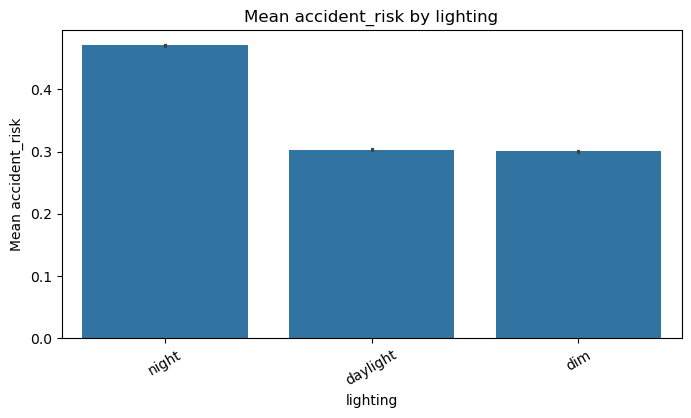

C:\Users\mones\AppData\Local\Temp\ipykernel_2972\1342992296.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = train.groupby(col)[target].mean().sort_values(ascending=False).index


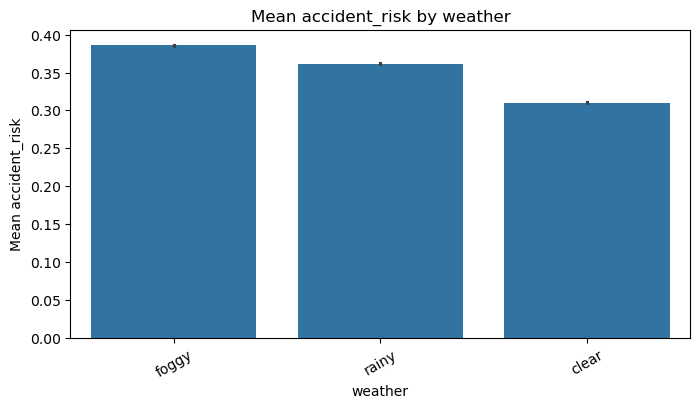

C:\Users\mones\AppData\Local\Temp\ipykernel_2972\1342992296.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = train.groupby(col)[target].mean().sort_values(ascending=False).index


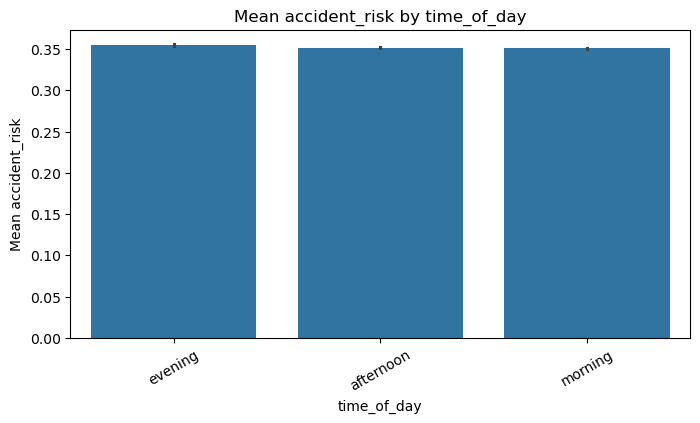

In [59]:
# Group all categorical columns and plot mean target value

target = 'accident_risk'
cat_cols = train.select_dtypes(include=['object','category']).columns

for col in cat_cols:
    order = train.groupby(col)[target].mean().sort_values(ascending=False).index
    plt.figure(figsize=(8,4))
    sns.barplot(data=train, x=col, y=target, order=order)
    plt.xticks(rotation=30)
    plt.ylabel(f"Mean {target}")
    plt.title(f"Mean {target} by {col}")
    plt.show()


## Encoding

In [ ]:
TARGET = 'accident_risk'

# Separate features and target (accident risk is wgat we're trying to predict)
X = train.drop(columns=[TARGET, 'id'])
y = train[TARGET].copy()
X_test = test.drop(columns=['id'])

# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['object','category']).columns
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)

# Align columns (important for Kaggle)
X_enc, X_test_enc = X_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

print("Train encoded shape:", X_enc.shape)
print("Test  encoded shape:", X_test_enc.shape)

Train encoded shape: (517754, 20)
Test  encoded shape: (172585, 20)
